In [123]:
!pip install -q pyannote.audio pyannote.core

import torch
import numpy as np
import pandas as pd
import os
from sklearn.manifold import TSNE
import umap
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from pyannote.audio.utils.signal import Binarize, Peak
from pyannote.core import Segment, notebook, SlidingWindowFeature, timeline
from IPython.display import clear_output
import soundfile as sf
import librosa
from sklearn.cluster import KMeans
import seaborn as sns

#Removed participant 17 (17XX) because they said hi or had a background noise
#See google doc for reference: https://docs.google.com/spreadsheets/d/1-K3pIs9BPLAsvY3_AYHyIfsLdbo0bF9XD1-ohPeZJJk/edit#gid=1936393955
raw='C:\\Users\\MrBrito\\Documents\\_Grad_School\\Rotations\\Satra\\egemaps_analysis\\Hellos\\input'
directory='C:\\Users\\MrBrito\\Documents\\_Grad_School\\Rotations\\Satra\\egemaps_analysis\\Hellos\\input_downsampled'

In [3]:
## DONT NEED TO RERUN
for filename in os.listdir(raw):
    if filename.endswith(".wav"):
        new_rate = 16000
        resamp, rate = librosa.load(os.path.join(raw, filename), sr=new_rate)
        sf.write(os.path.join(directory, filename), resamp, new_rate) 

In [4]:
# speech activity detection model trained on AMI training set
sad = torch.hub.load('pyannote/pyannote-audio', 'sad_ami')
# speaker change detection model trained on AMI training set
scd = torch.hub.load('pyannote/pyannote-audio', 'scd_ami')
# speaker embedding model trained on AMI training set
emb = torch.hub.load('pyannote/pyannote-audio', 'emb_ami')

Using cache found in C:\Users\MrBrito/.cache\torch\hub\pyannote_pyannote-audio_master
Using cache found in C:\Users\MrBrito/.cache\torch\hub\pyannote_pyannote-audio_master
Using cache found in C:\Users\MrBrito/.cache\torch\hub\pyannote_pyannote-audio_master
C:\Users\MrBrito\miniconda3\lib\site-packages\pyannote\audio\embedding\approaches\arcface_loss.py:170: FutureWarning: The 's' parameter is deprecated in favor of 'scale', and will be removed in a future release
  warnings.warn(msg, FutureWarning)


In [37]:
X, sid_per_sample = [], []
for filename in os.listdir(directory):
    if filename.endswith(".wav"): 
        clear_output(wait=True)
        one_file = {'uri': 'filename', 'audio': os.path.join(directory, filename)}
        
        #detect speaker time versus silence in sample
        sad_scores = sad(one_file)
        binarize = Binarize(offset=0.52, onset=0.52, log_scale=True, min_duration_off=0.1, min_duration_on=0.1)
        speech = binarize.apply(sad_scores, dimension=1)
        
        #extract speaker embeddings and crop only part with speech and remove silence
        embeddings = emb(one_file)
        for segment in speech:
            cropped = embeddings.crop(segment)
        
        X.append(np.mean(cropped, axis=0))

        # keep track of speaker label (for later scatter plot)
        sid_per_sample.append(filename[0:2])
        
        print("Processing" + str(filename))

X = pd.DataFrame(np.vstack(X))
sid, y_true = np.unique(sid_per_sample, return_inverse=True)
y_true=y_true+1
X.index=y_true

#remove participant 17
X=X.drop(17) 
y_true = np.delete(y_true, np.where(y_true==17))
sid = np.delete(sid, np.where(sid=='17'))

Processing1830.wav


In [191]:
tsne = TSNE(n_components=2, metric="cosine")
X2d = pd.DataFrame(tsne.fit_transform(X), index=y_true, columns = ['dim0', 'dim1'])

# k means
kmeans = KMeans(n_clusters=np.size(sid))
X2d['cluster'] = kmeans.fit_predict(X2d)

# get centroids
centroids = kmeans.cluster_centers_
cen_x = [i[0] for i in centroids] 
cen_y = [i[1] for i in centroids]
## add to tSNE cluster pd
xmap = {}
ymap = {}
[xmap.update({z:cen_x[z]}) for z in np.arange(len(cen_x))]
[ymap.update({z:cen_y[z]}) for z in np.arange(len(cen_y))]
X2d['cen_x'] = X2d.cluster.map(xmap)
X2d['cen_y'] = X2d.cluster.map(ymap)

#define and map colors
#based on cluster
colors = sns.color_palette("Paired", len(sid)+2)
cmap = {}
[cmap.update({z:colors[z]}) for z in np.arange(len(cen_x))]
X2d['c_clust'] = X2d.cluster.map(cmap)
X2d['c_part'] = [colors[z] for z in X2d.index]

C:\Users\MrBrito\miniconda3\lib\site-packages\sklearn\manifold\_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


In [ ]:
# plot 
fig, ax = plt.subplots(1, figsize=(15,12))

#plot data
#plt.scatter(X2d.dim0, X2d.dim1, c=X2d.c_part, alpha = 0.6, s=10)
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Cluster {}'.format(i+1), 
               markerfacecolor=mcolor, markersize=5) for i, mcolor in enumerate(colors)]
plt.legend(handles=legend_elements, bbox_to_anchor=(1.2, 1), loc='upper right')
plt.title('tSNE plot of clusters\n', loc='left', fontsize=22)

for x, y, t in zip(X2d.dim0, X2d.dim1, X2d.index):
    plt.text(x, y, str(t), color=colors[t], fontsize=12)

#plot centroids
#plt.scatter(cen_x, cen_y, marker='^', c=colors, s=70)
plt.scatter(cen_x, cen_y, marker='^', c='k', s=70)

#plot distances
for idx, val in X2d.iterrows():
    x = [val.dim0, val.cen_x,]
    y = [val.dim1, val.cen_y]
    #plt.plot(x, y, c=val.c_clust, alpha=0.2)
    plt.plot(x, y, c='0.8', alpha=0.2)

plt.show()

Text(0.5, 1.0, 'UMAP plot of participants')

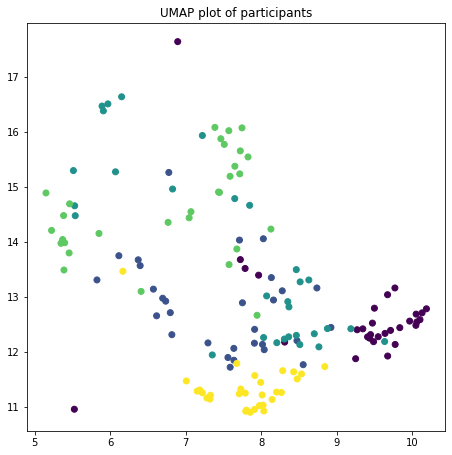

In [192]:
reducer=umap.UMAP()
X_2dU =reducer.fit_transform(X)

# plot 
fig, ax = plt.subplots()
fig.set_figheight(7.5)
fig.set_figwidth(7.5)
#plt.legend(y_true[:120], loc='center left', bbox_to_anchor=(1.0, 0.75))
#plt.scatter(*X_2dU.T, c=y_true)
plt.scatter(*X_2dU[:n,:].T, c=y_true[:n])
plt.title("UMAP plot of participants")